###### last update: April 5, 2022
### Author: Jerome O.

## Goal

Our objective is to develop a machine learning (ML) model that is able to predict the objective function value for our problem of interest. The surface used for the analysis is obtained from exhaustive sampling (see here). Thus, we know the full objective function surface and global optimal solution. Additionally, there are no missing data for this problem.

The process to compute the values for each location is computationally expensive. If we are able to develop a model with good accuracy, we can replace the expensive forward simulations with the machine learning model. This notebook describes a process to find such a model.

Ideally, the machine learning model will be used in an online fashion, where we build the model as we acquire the points from an underlying optimization algorithm that attemps to find the global objective function. It should be noted that this is not easy in practice and the surfaces (see below) are obtained from an exhaustive evaluation process described earlier. In practice, when we apply the ML model, we may not have enough points and the accuracy of the model may suffer in practice. Additionally, the ML model developed here may not generalize to other problem instances.

## View Data
<img src='3d_surface.png' width=400 height=300/>
<p><center>Figure 1: 3D surface plot of data</center></p>

<img src='2d_contour.png' width=400 height=300/>
<p><center>Figure 1: Contour plot of data</center></p>



In [619]:
import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib.pyplot as plt
from sklearn import (ensemble, preprocessing, tree)
from sklearn.metrics import (auc, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from yellowbrick.classifier import(ConfusionMatrix, ROCAUC)
from yellowbrick.model_selection import (LearningCurve)
import warnings
warnings.filterwarnings('ignore')
from scripts.utils import plot_data

In [219]:
num_rows, num_cols = 40, 40

### Gather Data

In [327]:
# read the file containing the data
def get_original_data_frame(filename='obj_surface_data.csv'):
    return pd.read_csv(filename)


In [328]:
data = get_original_data_frame()

## Data Exploration

In [246]:
# View statistics of the input data
data.describe()

,X1,X2,y
count,1600.000000,1600.000000,1600.000000
mean,20.500000,20.500000,67.597641
std,11.547005,11.547005,41.090698
min,1.000000,1.000000,7.098637
25%,10.750000,10.750000,37.517150
50%,20.500000,20.500000,57.329263
75%,30.250000,30.250000,92.644693
max,40.000000,40.000000,266.181500


### Distribution of X1 and X2

Text(0.5, 0, 'X2')

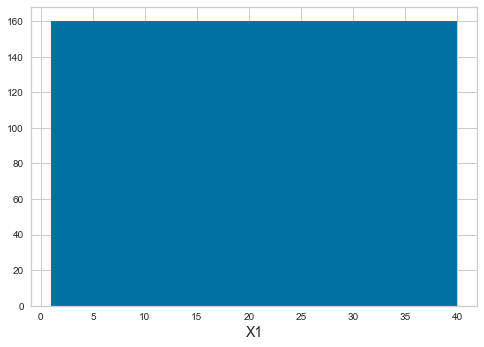

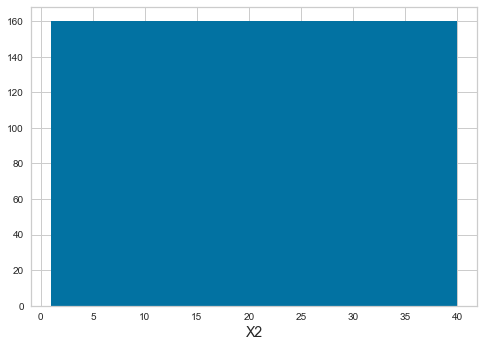

In [318]:
# Histogram of two independent variables X1 and X2
fontsize=14
data.iloc[:,0].hist()
plt.xlabel('X1', fontsize=fontsize)
plt.figure()
data.iloc[:,1].hist()
plt.xlabel('X2', fontsize=fontsize)

The distribution X1 and X2 is uniform.

### Distribution of Target Values

Text(0, 0.5, 'Frequency')

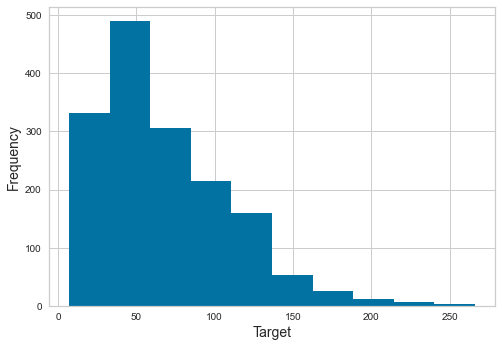

In [254]:
# Histogram of target variable
data.iloc[:,2].hist()
plt.xlabel('Target', fontsize=fontsize)
plt.ylabel('Frequency',fontsize=fontsize)

Target variable distribution is positively skewed with an arithmetic mean greater than the median (p50): 

In [255]:
data.iloc[:,2].describe()

count    1600.000000
mean       67.597641
std        41.090698
min         7.098637
25%        37.517150
50%        57.329263
75%        92.644693
max       266.181500
Name: y, dtype: float64

### Pandas Profile Report

In [243]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Clean Data
We do not have any missing data and all attributes and target values are present. Consequently, there is not much data cleaning to do.

## Create Feature Matrix and Target

In [590]:
X_orig = data.iloc[:,:2].values # feature matrix
y_orig = data.iloc[:,-1].values # target 

### Create New Target Categorical variables

We create categorical variable so we can apply classification algorithms to the problem. We create 3 different cases:
- 5 classes : C1, C2, ..., C5
- 10 classes: C1, C2, ..., C10
- 15 classes: C2, C2, ..., C15

In [637]:
# Function to generate the class labels
def generate_class_labels(num_classes):
    return [str(i) for i in range(num_classes)]

In [638]:
# generate the classes labels
case0_class_labels = generate_class_labels(2)
#case1_class_labels = generate_class_labels(5)
#case2_class_labels = generate_class_labels(10)
#case3_class_labels = generate_class_labels(15)

In [639]:
y

311     C1
372     C1
1317    C1
1578    C1
583     C1
        ..
1476    C1
1391    C1
1277    C1
540     C1
406     C1
Name: y, Length: 1600, dtype: object

In [640]:
# use pandas.cut, bins = defines the number of equal-width bins in the range of y
def bin_target(target, bins, labels):
    return pd.DataFrame(pd.cut(target, bins, labels=labels))

y_cat = bin_target(y_orig, bins=2, labels=case0_class_labels) 
#y_case1 = bin_target(y, bins=5, labels=case1_class_labels) 
#y_case2 = bin_target(y, bins=10,labels=case2_class_labels) 
#y_case3 = bin_target(y, bins=15,labels=case3_class_labels) 

In [641]:
y_cat.values

array([['0'],
       ['0'],
       ['0'],
       ...,
       ['0'],
       ['0'],
       ['0']], dtype=object)

In [642]:
y_cat.describe()

,0
count,1600
unique,2
top,0
freq,1501


### Distribution of target categorical variables

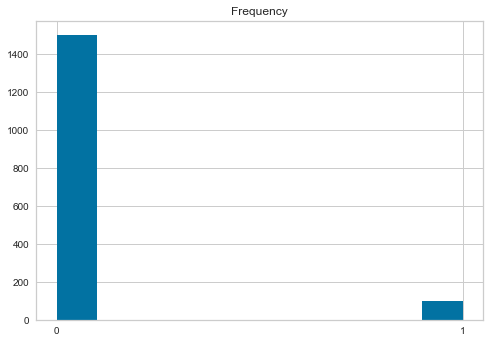

In [643]:
# View distribution of the new categorical classes
def plot_hist(df):
    plt.figure()
    plt.hist(df)
    plt.title('Frequency')
    
plot_hist(y_cat)


## Sample Data

Create train and test splits of the original data. The test_size is set to 0.33

In [644]:
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3, random_state=1)

In [645]:
# print the size of the train and test dataset
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)        

(1120, 2) (480, 2) (1120,) (480,)


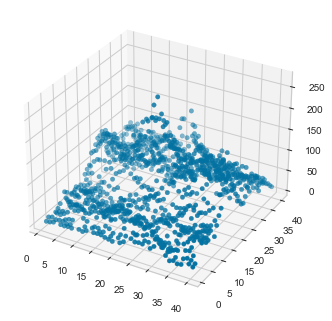

In [646]:
# plot the X_train and y_train data
plot_data(X_train, y_train)

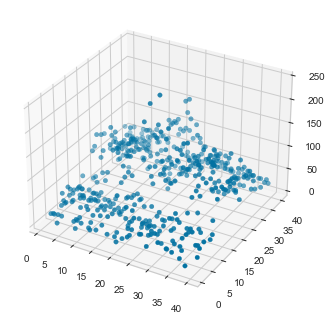

In [647]:
# plot the X_test and y_test data
plot_data(X_test, y_test)

## Normalize Data

Normalizing or preprocessing the data helps the machine learning models perform better. 


In [648]:
#scaler=preprocessing.StandardScaler() # if the variables have normal distribution, then they should be standardized
scalar = preprocessing.MinMaxScaler() # the variables have uniform distribution, so we normalize the variables instead
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_test_norm = pd.DataFrame(scaler.transform(X_test))

In [382]:
X_train_norm.describe()

,0,1
count,1.120000e+03,1.120000e+03
mean,4.123686e-17,5.075305e-17
std,1.000447e+00,1.000447e+00
min,-1.705446e+00,-1.682945e+00
25%,-8.385980e-01,-9.006490e-01
50%,2.824996e-02,-3.143152e-02
75%,8.950980e-01,8.377859e-01
max,1.675261e+00,1.707003e+00


In [383]:
X_test_norm.describe()

,0,1
count,480.000000,480.000000
mean,-0.050308,0.040098
std,1.002282,1.011695
min,-1.705446,-1.682945
25%,-0.925283,-0.813727
50%,-0.058435,0.055490
75%,0.808413,0.924708
max,1.675261,1.707003


In [649]:
# Add the previous steps into a function for easy replication
from sklearn.model_selection import StratifiedKFold
def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    
    # No stratify
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    # We can use a stratified version of a train/test split. This is achieved by passing the 'stratify' argument on
    # the call to train-test split
    # When the relative class sizes are different, accuracy is not a good evaluation metric
    # So when splitting up the data into training and test sets, use stratified sampling so the sets keep
    # a relative proportion of the classes. Pass in the parameter 'stratify' to achieve this
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42, stratify=y)
    train_C1, train_C2 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_C1, test_C2 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('Train-Test With Stratify: Train: 0=%d, 1=%d, 0/1=%d, Test: 0=%d, 1=%d, 0/1=%d' % 
          (train_C1, 
           train_C2, 
           train_C1/train_C2,
           test_C1, 
           test_C2, 
           test_C1/test_C2))
    cols = X.columns
    if std_cols:
        std = preprocessing.MinMaxScaler() # StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])
    
    return X_train, X_test, y_train, y_test

def add_categorical_target(df, y_cat):
    new_df = df.copy()
    new_df['y'] = y_cat
    return new_df
    

In [650]:
get_train_test_X_y(add_categorical_target(data, y_case0),'y')

Train-Test With Stratify: Train: 0=1051, 1=69, 0/1=15, Test: 0=450, 1=30, 0/1=15


(        X1    X2
 311   32.0   8.0
 372   13.0  10.0
 1317  38.0  33.0
 1578  19.0  40.0
 583   24.0  15.0
 ...    ...   ...
 1301  22.0  33.0
 980   21.0  25.0
 423   24.0  11.0
 534   15.0  14.0
 558   39.0  14.0
 
 [1120 rows x 2 columns],
         X1    X2
 1062  23.0  27.0
 1119  40.0  28.0
 492   13.0  13.0
 143   24.0   4.0
 1322   3.0  34.0
 ...    ...   ...
 1476  37.0  37.0
 1391  32.0  35.0
 1277  38.0  32.0
 540   21.0  14.0
 406    7.0  11.0
 
 [480 rows x 2 columns],
 311     0
 372     0
 1317    0
 1578    0
 583     0
        ..
 1301    0
 980     0
 423     0
 534     0
 558     0
 Name: y, Length: 1120, dtype: int64,
 1062    0
 1119    0
 492     0
 143     0
 1322    0
        ..
 1476    0
 1391    0
 1277    0
 540     0
 406     0
 Name: y, Length: 480, dtype: int64)

In [651]:
data_case0 = add_categorical_target(data.iloc[:,0:2], y_case0)
#data_case1 = add_categorical_target(data.iloc[:,0:2], y_case1)
#data_case2 = add_categorical_target(data.iloc[:,0:2], y_case2)
#data_case3 = add_categorical_target(data.iloc[:,0:2], y_case3)

In [653]:
X_train, X_test, y_train, y_test = get_train_test_X_y(data_case0, "y", size=0.3, std_cols=["X1", "X2"])

Train-Test With Stratify: Train: 0=1051, 1=69, 0/1=15, Test: 0=450, 1=30, 0/1=15


In [526]:
print(X_train.shape)

(1120, 2)


## Baseline Model

create a simple baseline model

In [654]:
from sklearn.dummy import DummyClassifier
def run_dummy_classification(X_train, X_test, y_train, y_test, name=''):    
    bm = DummyClassifier()
    bm.fit(X_train_norm, y_train)
    score = bm.score(X_test, y_test) * 100.0 # uses accuracy and this can be misleading
    if name:
        print(f'{name.title()} : score = {score}%')
    return score

In [655]:
run_dummy_classification(*get_train_test_X_y(add_categorical_target(data, y_case0),'y'), name='case0')
#run_dummy_classification(X_train1, X_test1, y_train1, y_test1, name='case1')
#run_dummy_classification(X_train2, X_test2, y_train2, y_test2, name='case2')
#run_dummy_classification(X_train3, X_test3, y_train3, y_test3, name='case3')

Train-Test With Stratify: Train: 0=1051, 1=69, 0/1=15, Test: 0=450, 1=30, 0/1=15
Case0 : score = 93.75%


93.75

Note that Case0 (with 2 classes) results in a 93.75% accuracy. This case highlights the issue with using accuracy as a metric for imbalanced datasets. There are 1501 cases of C1 and 98 cases of C2. 

In [532]:
# accuracy for predicting the C1 class
1501/1600 

0.938125

## Various Models

Next, we try different algorithms on the data.

In [656]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost 
xgboost.set_config(verbosity=0)

In [657]:
"""
roc_auc only works for binary classification problem, and will not work for multi-classification
problem. 
"""
all_models = [DummyClassifier, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, 
              GaussianNB, SVC, RandomForestClassifier, xgboost.XGBClassifier]

# Stratification for imbalanced datasets
# We need to use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold.
# It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data
# to match the distribution in the complete training dataset

# Stratified sampling: Split the dataset in such a way that we preserve the imbalanced class distribution in each
# fold
# The target variable (y), the class is used to control the sampling process

# So we use the stratified version of k-fold cross-validation that preserves class distribution in each fold, and 
# this will enforce the class distribution in each split of the data to  match the distribution in the complete
# training dataset

def summarize_distribution(kfold, X, y):
    X = X.values
    y = y.values
    for train_ix, test_ix in kfold.split(X, y):
        # select the rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # summarize the train and test composition
        train_C1, train_C2 = len(train_y[train_y=='C1']), len(train_y[train_y=='C2'])
        test_C1, test_C2 = len(test_y[test_y=='C1']), len(test_y[test_y=='C2'])
        print('>Train: #C1=%d, #C2=%d, Test: #C1=%d, #C2=%d' % (train_C1, train_C2, test_C1, test_C2))
        
def run_multiple_models(X_train, X_test, y_train, y_test):
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    for model in all_models:
        cls = model()
        #kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=10)
        
        # Use this option to preserve the class distributions in each dataset
        kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        # Enumerate the splits and summarize the distributions
        summarize_distribution(kfold, X, y)
        s = model_selection.cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)
        print(f"{model.__name__:22} AUC: "
              f"{s.mean():.3f} STD: {s.std():.2f}")
        
def run_cases():    
    print(f'Case={id}')
    run_multiple_models(*get_train_test_X_y(add_categorical_target(data, y_case0),'y'))    
    print()

In [658]:
run_cases()

Case=1599
Train-Test With Stratify: Train: 0=1051, 1=69, 0/1=15, Test: 0=450, 1=30, 0/1=15
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
DummyClassifier        AUC: 0.500 STD: 0.00
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
>Train: #C1=0, #C2=0, Test: #C1=0, #C2=0
LogisticRegression     AUC: 0.601 STD: 0.07
>

## Stacking models
A stacking classifier takes other models and users their output to predict a target or label. 


<img src="mlxtend.png" width=800 height=500 />
source: https://www.geeksforgeeks.org/stacking-in-machine-learning-2/

Stacking: 
Stacking is a way of ensembling classification or regression models it consists of two-layer estimators. The first layer consists of all the baseline models that are used to predict the outputs on the test datasets. The second layer consists of Meta-Classifier or Regressor which takes all the predictions of baseline models as an input and generate new predictions.

In [659]:
from mlxtend.classifier import (StackingClassifier)

In [660]:
clfs = [x() for x in [LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier]]

In [661]:
y_case0.describe()


,0
count,1600
unique,2
top,0
freq,1501


In [662]:
y_train

311     0
372     0
1317    0
1578    0
583     0
       ..
1301    0
980     0
423     0
534     0
558     0
Name: y, Length: 1120, dtype: int64

In [663]:
XX = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)])
yy = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)])
stack = StackingClassifier(classifiers=clfs, meta_classifier=LogisticRegression())
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
s = model_selection.cross_val_score(stack, XX, yy, scoring="roc_auc", cv=kfold)

In [664]:
print(f"{stack.__class__.__name__} "
      f"AUC: {s.mean():.3f} STD: {s.std():.2f}")

StackingClassifier AUC: 0.903 STD: 0.07


## Create Model

In [665]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)

In [666]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate Model

Evaluate the model using the test data to see how well the model generalizes to unseen data. The .score method of a classifier returns the average of the prediction accuracy

In [667]:
rf.score(X_test, y_test)

0.9708333333333333

We can compute other metrics, e.g., precision

In [668]:
import sklearn
rf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [669]:
sklearn.metrics.precision_score(y_test, rf.predict(X_test))

0.7666666666666667

### Feature importance

A benefit of tree-based models is that we can extract information about feature importance. 

The feature importance tells you how much a feature contributes to the model. 


In [670]:
for col, val in sorted(zip(X_train.columns,rf.feature_importances_,),key=lambda x: x[1],reverse=True,)[:5]:
    print(f"{col:10}{val:10.3f}")

X2             0.648
X1             0.352


Feature importance can be computed by looking at the increase in error of the model if the feature is removed.


## Optimize Model

Models have hyperparameters that control their performance. We obtain the best performance of out model if we can find optimal values for the hyperparameters. 

In [672]:
rf4 = ensemble.RandomForestClassifier()

In [671]:
params = {"max_features": [0.4, "auto"],"n_estimators": [15, 200],"min_samples_leaf": [1, 0.1],"random_state": [42]}

In [673]:
cv = model_selection.GridSearchCV(rf4, params, n_jobs=-1).fit(X_train, y_train)

In [675]:
print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


Now create another RandomForestClassifier and use the features from above

In [676]:
rf5 = ensemble.RandomForestClassifier(**{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42})

In [677]:
rf5.fit(X_train, y_train)

RandomForestClassifier(max_features=0.4, n_estimators=200, random_state=42)

In [678]:
rf5.score(X_test, y_test)

0.9729166666666667

## Confusion Matrix




In [685]:
y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[444,   6],
       [  7,  23]])

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

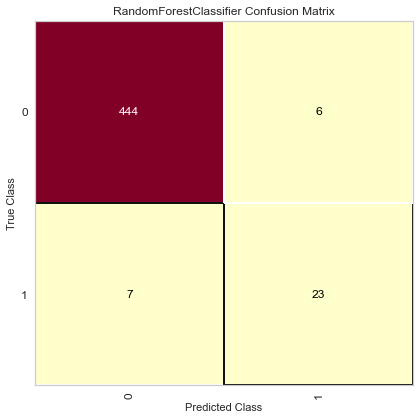

In [689]:
mapping = {0: '0', 1: '1'}
fig, ax = plt.subplots(figsize=(6,6))
cm_viz = ConfusionMatrix(rf5, classes=['0', '1'], label_encoder=mapping,)
cm_viz.score(X_test, y_test)
cm_viz.poof()

## ROC Curve

- Use to classify different classifiers
- Using the area under the curve (AUC), we can get a metric to compare different classifiers. The one with the higher AUC is the better classifer
- The more the curve is towards the top left hand corner the better.
- AUC closer to 1 is better, a random classifier as AUC of 0.5, AUC of < 0.5 is poor model

In [690]:
y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.8766666666666666

Using Yellowbrick to visualize the plot

In [693]:
y_test

1062    0
1119    0
492     0
143     0
1322    0
       ..
1476    0
1391    0
1277    0
540     0
406     0
Name: y, Length: 480, dtype: int64

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

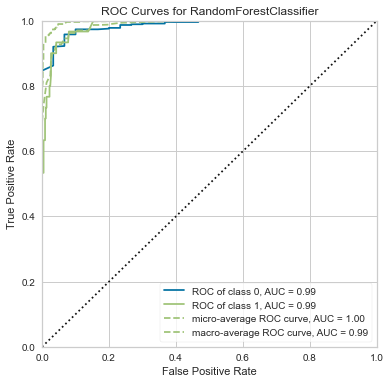

In [697]:
fig, ax = plt.subplots(figsize=(6,6))
roc_viz = ROCAUC(rf5, is_fitted=True)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()

## Classification Report

In [680]:
from sklearn.metrics import classification_report
y_pred=rf5.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       450
           1       0.79      0.77      0.78        30

    accuracy                           0.97       480
   macro avg       0.89      0.88      0.88       480
weighted avg       0.97      0.97      0.97       480



Pay attention to the Macro avg if as we do have class imbalance. Macro average does not take class imbalance into account

In [681]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.984479,0.793103,0.972917,0.888791,0.972518
recall,0.986667,0.766667,0.972917,0.876667,0.972917
f1-score,0.985572,0.779661,0.972917,0.882616,0.972702
support,450.000000,30.000000,0.972917,480.000000,480.000000


# Some metrics to consider to use and consider
- Accuracy
- Precision and Recall
- ROCAUC
- Confusion Matrix
- Classification Report
More metrics in model_evaluation module of sklearn

In [683]:
450/480*0.98 + 30/450*0.79

0.9714166666666666

## Learning Curve

- A learning curve is used to tell if we have enough training data
- if the CV score continues to climb, then we might need to gather more data. This means that adding more data continues to improve our cross validation score

From yellowbricks documentation:

- A learning curve shows the relationship of the training score versus the cross validated test score for an estimator with a varying number of training samples. This visualization is typically used to show two things:

    1. How much the estimator benefits from more data (e.g. do we have “enough data” or will the estimator get better if used in an online fashion).

    2. If the estimator is more sensitive to error due to variance vs. error due to bias.

The curves are plotted with the mean scores, however variability during cross-validation is shown with the shaded areas that represent a standard deviation above and below the mean for all cross-validations. If the model suffers from error due to bias, then there will likely be more variability around the training score curve. If the model suffers from error due to variance, then there will be more variability around the cross validated score.

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

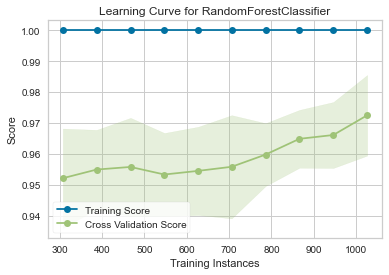

In [700]:
import numpy as np
fig, ax = plt.subplots(figsize=(6,4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(rf5, cv=cv, train_sizes=sizes, scoring='f1_weighted', n_jobs=4, ax=ax)
lc_viz.fit(X_train, y_train)
lc_viz.poof()

## Deploy Model

- Use python's pickle module, we can save and load models. 
- Once the model is loaded, we can call its .predict(...) method to get a classification or regression results

In [701]:
import pickle

In [703]:
pic = pickle.dumps(rf5)
rf6 = pickle.loads(pic)
y_pred = rf6.predict(X_test)
roc_auc_score(y_test, y_pred)

0.8766666666666666

Options for deploying maching learning models include:
- Flask
- Clipper
- Pipeline
- Google's Cloud Machine Learning Engine